In [ ]:
#| default_exp launcher_r

# LIBS

In [ ]:
#| hide
%load_ext autoreload
%autoreload 2

In [ ]:
#| export
import numba
import numpy as np
from rl_opts.robot_search import RobotSearch, run_robot_training_parallel
from numba import set_num_threads 
from tqdm import tqdm
import pathlib
import os
numba.get_num_threads()
import matplotlib.pyplot as plt

# FUNCTIONS

In [ ]:
def save_args_to_text_file(foldername, filename, **args):
    # Create directory if it does not exist yet
    if not os.path.exists(foldername):
        os.makedirs(foldername)
    
    # Construct the full file path
    file_path = os.path.join(foldername, filename)
    with open(filename, 'w+') as file:
        for key, value in args.items():
            file.write(f"{key}: {value}\n")

In [ ]:
def get_prob_action(action: int, #Index of the action
                    h_matrix: np.array #h matrix with shape (number agents, number actions, number states)
                   )-> np.array: #array containing the probability of the given action for all states, for all agents. Shape (number agents, number states)
    "Given the h_matrix and the action, it gives an array with the probability of the given action for each state"
    
    number_agents = np.shape(h_matrix)[0]
    number_states = np.shape(h_matrix)[2]
    
    prob_action = np.zeros([number_agents, number_states])
    
    for ag in range(number_agents):
        for s in range(number_states):
            prob_action[ag, s] = h_matrix[ag, action, s] / np.sum(h_matrix[ag,:,s])
    
    return prob_action
    

In [ ]:
def get_policies(h_matrix: np.array #h matrix with shape (number agents, number actions, number states)
                   )-> np.array: #array containing the probability of the given action for all states, for all agents. Shape (number agents, number states)
    "Given the h_matrix for all agents, it gives an array with the policies for all agents"
    
    number_agents = np.shape(h_matrix)[0]
    number_actions = np.shape(h_matrix)[1]
    number_states = np.shape(h_matrix)[2]
    
    policies = np.zeros([number_agents, number_states, number_actions])
    
    for ag in range(number_agents):
        for s in range(number_states):
            for a in range(number_actions):
                policies[ag, s, a] = h_matrix[ag, a, s] / np.sum(h_matrix[ag,:,s])
    
    return policies
    

# Single robot

## EXP_1

Goal of this experiment: run a grid of learning hyperparameters with less training time, to see what is the best configuration for the real robots to actually learn in a shorter amount of time. We will then get an optimal policy for the given training time (which may not be the optimal policy overall for that env).

### Input parameters

We put the parameters of the most up-to-date robots, setting up a scale of robot_radius to target_radius of approx 2:1. The time delay is 4 (time delay=3 is equivalent to lc=1 in the ideal single agent scenario).

- Arena of 96x96 cm

- Nt: we set 92 to get a similar density (around 3,14% of the total area) to the previous case with an arena of 100x100

- avg_vel: such that robot traverses the arena in 100 steps - 0.96 cm/step. 

- avg_turn_angle: robot can rotate 50 degrees per second, and we set now the step to be 0.5s, so 25 degrees. 
- std: 10% of the means


In [ ]:
#| export

# Training spec
TIME_EP = 5000
EPISODES = 1200
N_AGENTS = 100

# Environment 
Nt = 92; L = 96; r = 1; tau = 4; agent_radius = 1.5; avg_vel = 0.96; std_vel = 0.1; avg_turn_angle = 0.44; std_turn_angle = 0.04;


# Agent (we restrict the size of the h matrix to a maximum counter value of TIME_EP)
size_state_space = np.array([TIME_EP], dtype=np.int64)
initial_prob_distr = (np.array([0.988, 0.012/2, 0.012/2])*np.ones((3, TIME_EP)).transpose()).transpose()

# Grid of learning hyperparameters
gamma_damping_list = np.hstack((np.linspace(0.000001, 0.00001, 5),np.linspace(0.00001, 0.0001, 5)[1:]))
eta_glow_damping_list = np.array([0.0001,0.001,0.01, 0.04, 0.08, 0.1, 0.2, 0.3])

Main folder, where we also save the main parameters common to all learning cases:

In [ ]:
base_folder = 'C:/Users/andrea/Desktop/collective_foraging/results/single_robot_final/exp_1/'

In [ ]:
save_args_to_text_file(base_folder, base_folder +'input_args.txt',
                       N_agents = N_AGENTS, time_ep = TIME_EP, episodes = EPISODES,
                       tau = tau, 
                       Nt = Nt, L = L, r = r, agent_radius = agent_radius, avg_vel = avg_vel, std_vel=std_vel, avg_turn_angle=avg_turn_angle, std_turn_angle=std_turn_angle,
                       initial_prob_continue = initial_prob_distr[0,0])

### Run

Run the parallel agents and save their rewards and final h matrices for each hyperparameter pair of (gamma, eta):

In [ ]:
# Iterate through all combinations
for gamma_damping in gamma_damping_list:
    for eta_glow_damping in eta_glow_damping_list:

        # Create folder name
        foldername = f"{base_folder}gamma_{gamma_damping:.6f}_eta_{eta_glow_damping:.4f}/"
        os.makedirs(foldername, exist_ok=True)

        # Run training
        rewards, h_matrix = run_robot_training_parallel(episodes = int(EPISODES), 
                                                        time_ep = int(TIME_EP), 
                                                        N_agents = N_AGENTS, 
                                                        Nt = Nt, L = L, r = r, tau = tau, agent_radius = agent_radius,
                                                        avg_vel = avg_vel, std_vel=std_vel, avg_turn_angle=avg_turn_angle, std_turn_angle=std_turn_angle,
                                                        num_actions = 3,
                                                        size_state_space = size_state_space,
                                                        gamma_damping = gamma_damping,
                                                        eta_glow_damping = eta_glow_damping, 
                                                        initial_prob_distr = initial_prob_distr)
        
        np.save(foldername + 'h_matrices.npy', h_matrix)
        np.save(foldername+'rewards.npy', rewards)

### Plot rewards

Load first: 
- eta_glow_damping_list
- gamma_damping_list 
- base_folder


Final average rewards for each hyperparameter pair:
γ=0.0000010, η=0.00010 -> final avg reward = 0.0027
γ=0.0000010, η=0.00100 -> final avg reward = 0.0061
γ=0.0000010, η=0.01000 -> final avg reward = 0.0132
γ=0.0000010, η=0.04000 -> final avg reward = 0.0142
γ=0.0000010, η=0.08000 -> final avg reward = 0.0140
γ=0.0000010, η=0.10000 -> final avg reward = 0.0135
γ=0.0000010, η=0.20000 -> final avg reward = 0.0126
γ=0.0000010, η=0.30000 -> final avg reward = 0.0130
γ=0.0000033, η=0.00010 -> final avg reward = 0.0041
γ=0.0000033, η=0.00100 -> final avg reward = 0.0085
γ=0.0000033, η=0.01000 -> final avg reward = 0.0142
γ=0.0000033, η=0.04000 -> final avg reward = 0.0171
γ=0.0000033, η=0.08000 -> final avg reward = 0.0156
γ=0.0000033, η=0.10000 -> final avg reward = 0.0151
γ=0.0000033, η=0.20000 -> final avg reward = 0.0139
γ=0.0000033, η=0.30000 -> final avg reward = 0.0125
γ=0.0000055, η=0.00010 -> final avg reward = 0.0053
γ=0.0000055, η=0.00100 -> final avg reward = 0.0098
γ=0.0000055

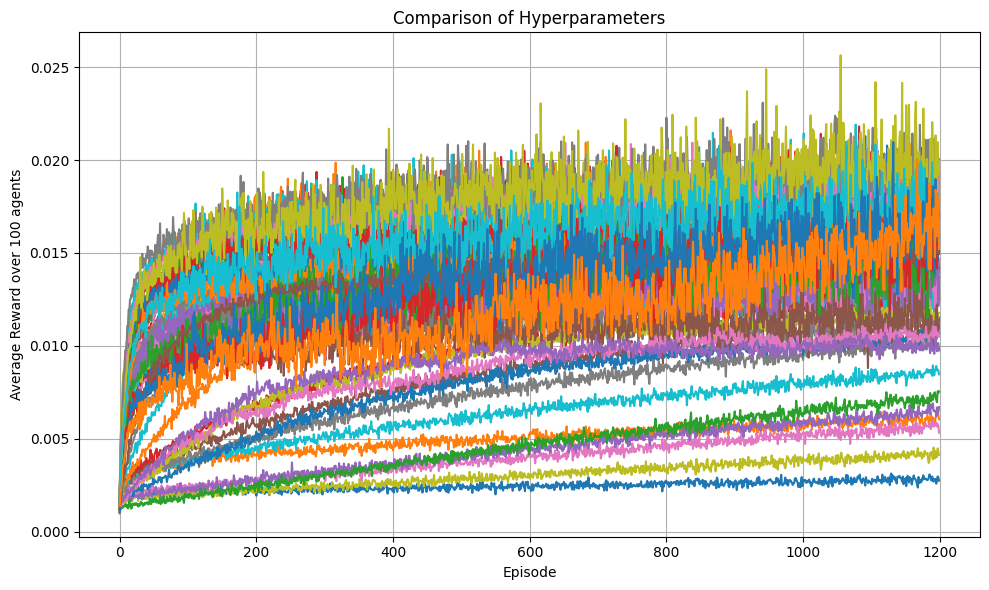

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt


plt.figure(figsize=(10, 6))

# Choose how many points you want in the plot
n_points = EPISODES  

final_rewards = {}  # store final reward for each hyperparameter pair


for gamma_damping in gamma_damping_list:
    for eta_glow_damping in eta_glow_damping_list:

        foldername3 = f"{base_folder}gamma_{gamma_damping:.6f}_eta_{eta_glow_damping:.4f}/"
        rewards_path = os.path.join(foldername3, 'rewards.npy')

        if os.path.exists(rewards_path):
            # Load with memory-mapping (does not load fully into RAM)
            rewards = np.load(rewards_path, mmap_mode='r')

            # Compute mean along axis 0
            avg_rewards = rewards.mean(axis=0)

            # Downsample by reshaping into blocks
            block_size = len(avg_rewards) // n_points
            if block_size > 1:
                avg_rewards = avg_rewards[:block_size*n_points].reshape(n_points, block_size).mean(axis=1)
            
            # Store final average reward
            final_avg = avg_rewards[-1]
            final_rewards[(gamma_damping, eta_glow_damping)] = final_avg

            label = f"γ={gamma_damping:.3f}, η={eta_glow_damping:.3f}"
            plt.plot(avg_rewards)
        else:
            print(f"Warning: File not found {rewards_path}")

# Print final rewards in a readable way
print("\nFinal average rewards for each hyperparameter pair:")
for (gamma, eta), final in final_rewards.items():
    print(f"γ={gamma:.7f}, η={eta:.5f} -> final avg reward = {final:.4f}")
    
# Find the hyperparameter pair with the maximum final reward
best_pair, best_reward = max(final_rewards.items(), key=lambda x: x[1])
print(f"\nBest hyperparameters: γ={best_pair[0]:.7f}, η={best_pair[1]:.5f} -> final avg reward = {best_reward:.4f}")


plt.xlabel(f"Episode")
plt.ylabel(f"Average Reward over {np.shape(rewards)[0]} agents")
plt.title("Comparison of Hyperparameters")
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
block_size

1

#### Best curves

Plot only the best 5 and 10 curves, with the best highlighted. Only 600 points are plotted, where each point shows the average over 10000 time steps and over 100 agents.

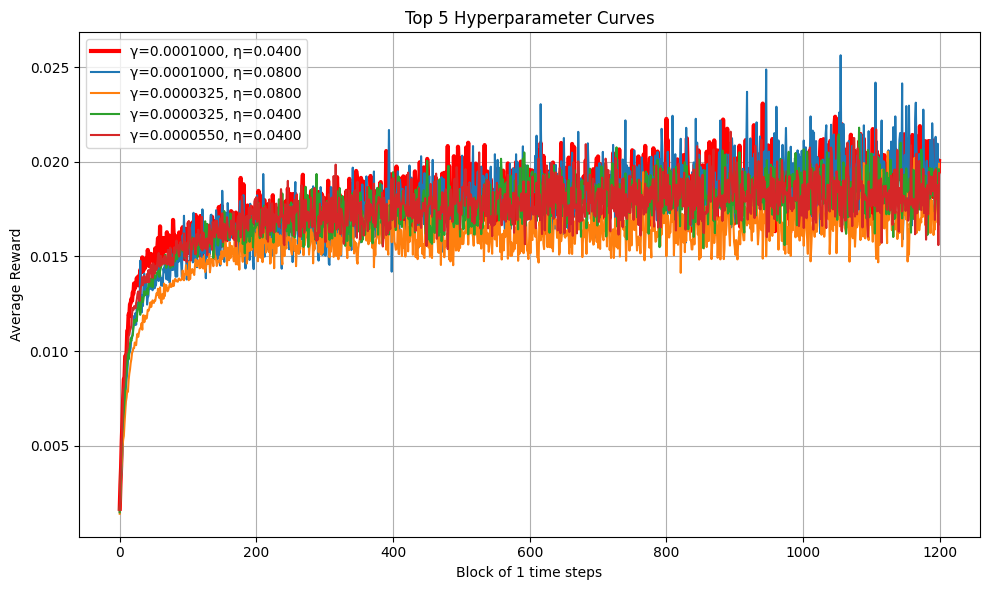


Best hyperparameters: γ=0.0001000, η=0.0400 -> final avg reward = 0.0200


In [ ]:


# Number of points for downsampled plotting
n_points = EPISODES
best_X_curves = 5

final_rewards = {}  # store final reward for each hyperparameter pair
avg_rewards_dict = {}  # store avg_rewards arrays for plotting later

# Step 1: Load and compute averages
for gamma_damping in gamma_damping_list:
    for eta_glow_damping in eta_glow_damping_list:

        foldername3 = f"{base_folder}gamma_{gamma_damping:.6f}_eta_{eta_glow_damping:.4f}/"
        rewards_path = os.path.join(foldername3, 'rewards.npy')

        if os.path.exists(rewards_path):
            rewards = np.load(rewards_path, mmap_mode='r')
            avg_rewards = rewards.mean(axis=0)

            # Downsample for plotting
            block_size = len(avg_rewards) // n_points
            if block_size > 1:
                avg_rewards_downsampled = avg_rewards[:block_size*n_points].reshape(n_points, block_size).mean(axis=1)
            else:
                avg_rewards_downsampled = avg_rewards

            avg_rewards_dict[(gamma_damping, eta_glow_damping)] = avg_rewards_downsampled
            
            # Store final average reward
            final_avg = avg_rewards_downsampled[-1]
            final_rewards[(gamma_damping, eta_glow_damping)] = final_avg
            
        else:
            print(f"Warning: File not found {rewards_path}")

# Step 2: Select the "best_X_curves" best hyperparameter pairs
top_5_pairs = sorted(final_rewards.items(), key=lambda x: x[1], reverse=True)[:best_X_curves]

best_pair, best_reward = top_5_pairs[0]

# Step 3: Plot only the top 5 curves
plt.figure(figsize=(10, 6))

for pair, reward in top_5_pairs:
    curve = avg_rewards_dict[pair]
    label = f"γ={pair[0]:.7f}, η={pair[1]:.4f}"
    if pair == best_pair:
        plt.plot(curve, label=label, linewidth=3, color='red')  # highlight best
    else:
        plt.plot(curve, label=label, linewidth=1.5)

plt.xlabel(f"Block of {block_size} time steps")
plt.ylabel("Average Reward")
plt.title("Top 5 Hyperparameter Curves")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print(f"\nBest hyperparameters: γ={best_pair[0]:.7f}, η={best_pair[1]:.4f} -> final avg reward = {best_reward:.4f}")


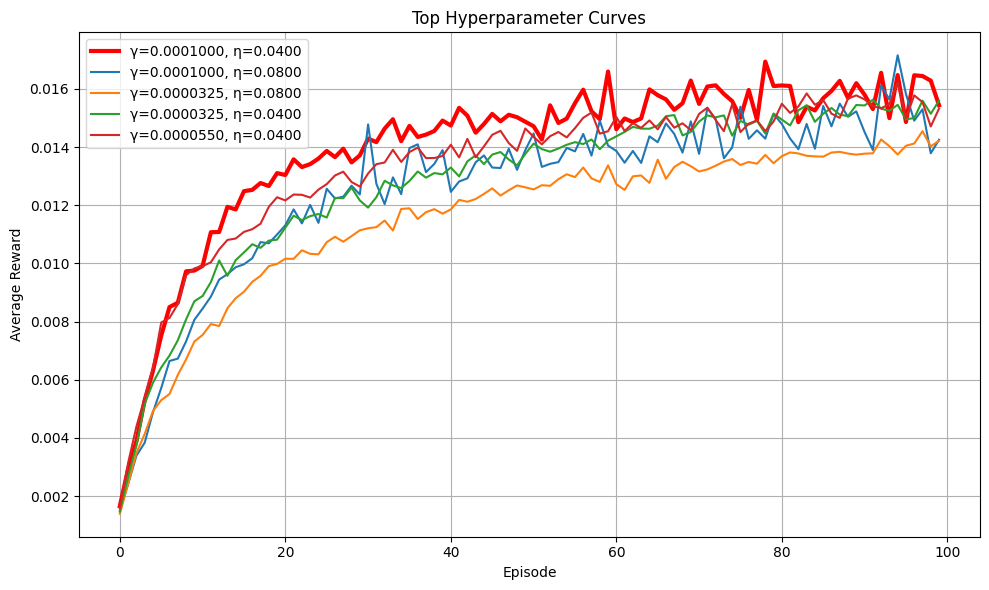

In [ ]:
# Step 2: Select the "best_X_curves" best hyperparameter pairs
best_X_curves = 5
until_episode = 100
top_pairs = sorted(final_rewards.items(), key=lambda x: x[1], reverse=True)[:best_X_curves]

best_pair, best_reward = top_pairs[0]

# Step 3: Plot only the top 5 curves
plt.figure(figsize=(10, 6))

for pair, reward in top_pairs:
    curve = avg_rewards_dict[pair][:until_episode]
    label = f"γ={pair[0]:.7f}, η={pair[1]:.4f}"
    if pair == best_pair:
        plt.plot(curve, label=label, linewidth=3, color='red')  # highlight best
    else:
        plt.plot(curve, label=label, linewidth=1.5)

plt.xlabel("Episode")
plt.ylabel("Average Reward")
plt.title("Top Hyperparameter Curves")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Plot of the cumulative reward until step 600.000 of the best 10 curves:

Parameters of those 10 curves and final rewards (avg reward of the last block of 10000 steps over 100 agents):

In [ ]:
top_pairs

[((7.75e-05, 0.04), 0.019019),
 ((0.0001, 0.1), 0.018973),
 ((0.0001, 0.04), 0.018722000000000003),
 ((5.5e-05, 0.04), 0.018401),
 ((5.5e-05, 0.01), 0.018286),
 ((3.2500000000000004e-05, 0.1), 0.017901),
 ((3.2500000000000004e-05, 0.04), 0.017854),
 ((7.75e-06, 0.04), 0.017819),
 ((7.75e-05, 0.08), 0.017781),
 ((7.75e-05, 0.2), 0.017755)]

In [ ]:
best_pair

(7.75e-05, 0.04)

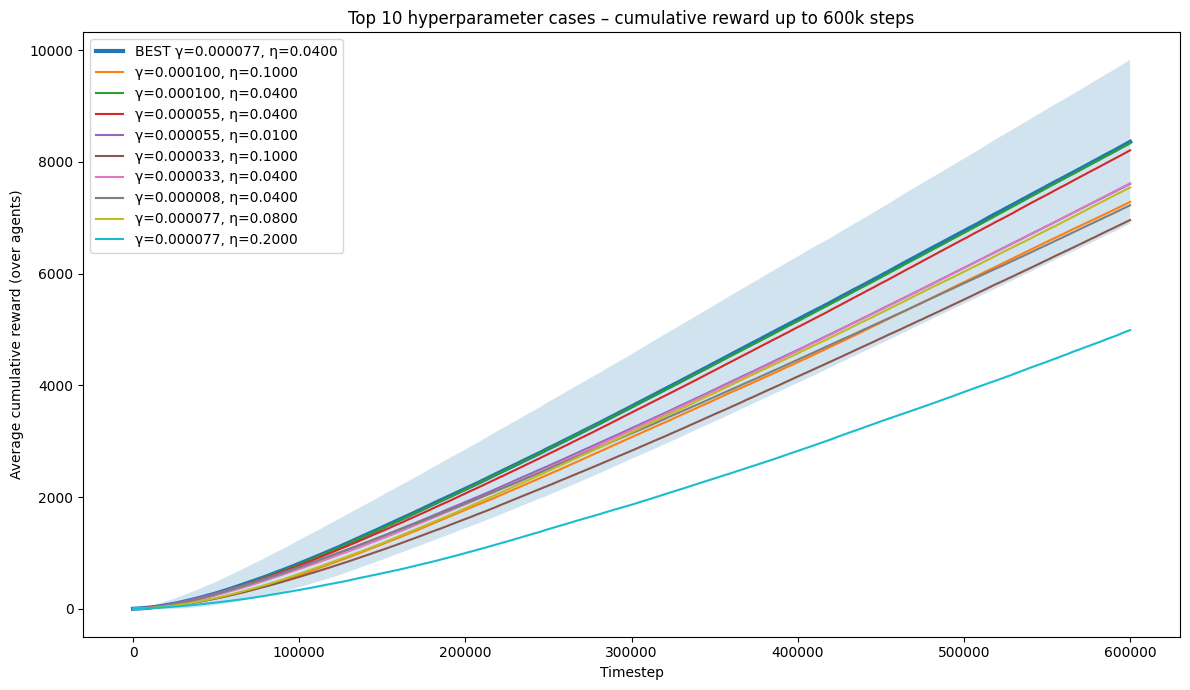

In [ ]:


plt.figure(figsize=(12, 7))

for (gamma, eta), _ in top_pairs:
    folder = f"{base_folder}gamma_{gamma:.6f}_eta_{eta:.4f}/"
    rewards = np.load(folder + "rewards.npy", mmap_mode='r')  # shape (N_agents, timesteps)
    
    # cumulative reward along timesteps (axis=1)
    cum_rewards = rewards.cumsum(axis=1)
    
    # average and std across agents
    avg_cum_rewards = cum_rewards.mean(axis=0)
    std_cum_rewards = cum_rewards.std(axis=0)
    
    # restrict to 600k steps
    steps_to_plot = min(600_000, avg_cum_rewards.shape[0])
    timesteps = np.arange(steps_to_plot)
    
    # Highlight the best
    if (gamma, eta) == best_pair:
        plt.plot(timesteps,
                 avg_cum_rewards[:steps_to_plot],
                 linewidth=3,
                 label=f"BEST γ={gamma:.6f}, η={eta:.4f}")
        # Shaded area = ± std
        plt.fill_between(timesteps,
                     (avg_cum_rewards - std_cum_rewards)[:steps_to_plot],
                     (avg_cum_rewards + std_cum_rewards)[:steps_to_plot],
                     alpha=0.2)
    else:
        plt.plot(timesteps,
                 avg_cum_rewards[:steps_to_plot],
                 linewidth=1.5,
                 label=f"γ={gamma:.6f}, η={eta:.4f}")
    
    

plt.xlabel("Timestep")
plt.ylabel("Average cumulative reward (over agents)")
plt.title("Top 10 hyperparameter cases – cumulative reward up to 600k steps")
plt.legend()
plt.tight_layout()
plt.show()


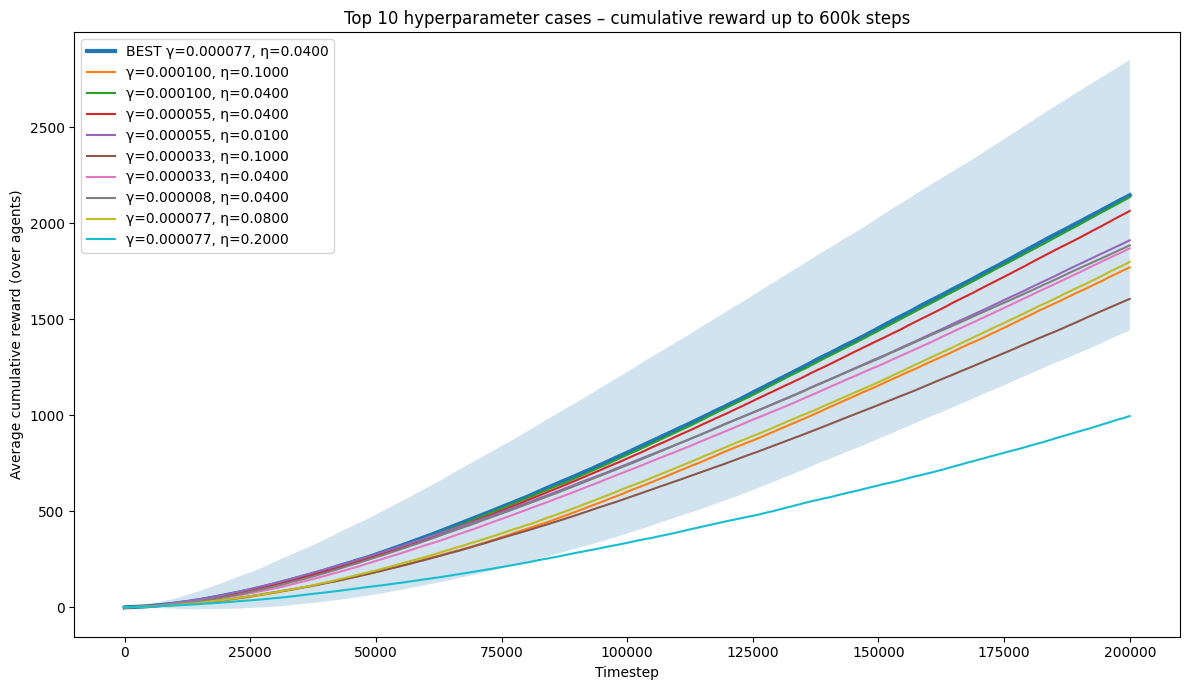

In [ ]:


plt.figure(figsize=(12, 7))

for (gamma, eta), _ in top_pairs:
    folder = f"{base_folder}gamma_{gamma:.6f}_eta_{eta:.4f}/"
    rewards = np.load(folder + "rewards.npy", mmap_mode='r')  # shape (N_agents, timesteps)
    
    # cumulative reward along timesteps (axis=1)
    cum_rewards = rewards.cumsum(axis=1)
    
    # average and std across agents
    avg_cum_rewards = cum_rewards.mean(axis=0)
    std_cum_rewards = cum_rewards.std(axis=0)
    
    # restrict to 600k steps
    steps_to_plot = min(200_000, avg_cum_rewards.shape[0])
    timesteps = np.arange(steps_to_plot)
    
    # Highlight the best
    if (gamma, eta) == best_pair:
        plt.plot(timesteps,
                 avg_cum_rewards[:steps_to_plot],
                 linewidth=3,
                 label=f"BEST γ={gamma:.6f}, η={eta:.4f}")
        # Shaded area = ± std
        plt.fill_between(timesteps,
                     (avg_cum_rewards - std_cum_rewards)[:steps_to_plot],
                     (avg_cum_rewards + std_cum_rewards)[:steps_to_plot],
                     alpha=0.2)
    else:
        plt.plot(timesteps,
                 avg_cum_rewards[:steps_to_plot],
                 linewidth=1.5,
                 label=f"γ={gamma:.6f}, η={eta:.4f}")
    
    

plt.xlabel("Timestep")
plt.ylabel("Average cumulative reward (over agents)")
plt.title("Top 10 hyperparameter cases – cumulative reward up to 600k steps")
plt.legend()
plt.tight_layout()
plt.show()


#### Hyperparameters grid

Plot of the final rewards as a function of gamma, for the eta value that got the max reward.

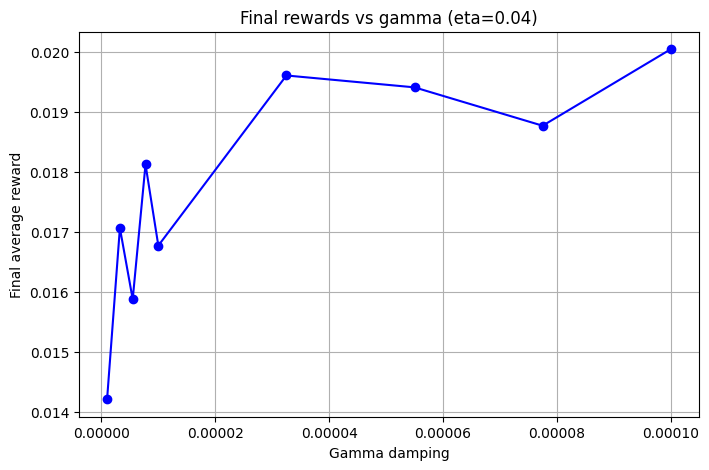

In [ ]:
# Assuming final_rewards dict exists
max_eta = 0.04  # the eta value for the max reward

gammas = []
finals = []

for gamma in gamma_damping_list:
    pair = (gamma, max_eta)
    if pair in final_rewards:
        gammas.append(gamma)
        finals.append(final_rewards[pair])
    else:
        print(f"Warning: missing pair {pair}")

plt.figure(figsize=(8,5))
plt.plot(gammas, finals, marker='o', linestyle='-', color='blue')
plt.xlabel("Gamma damping")
plt.ylabel("Final average reward")
plt.title(f"Final rewards vs gamma (eta={max_eta})")
plt.grid(True)



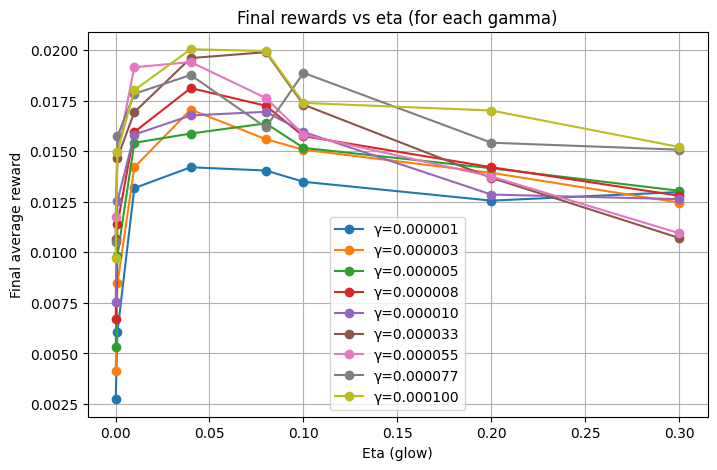

In [ ]:
# Assuming final_rewards dict exists



plt.figure(figsize=(8,5))

for gamma in gamma_damping_list:
    etas = []
    finals = []
    for eta in eta_glow_damping_list:
        pair = (gamma, eta)
        if pair in final_rewards:
            etas.append(eta)
            finals.append(final_rewards[pair])
        else:
            print(f"Warning: missing pair {pair}")


    plt.plot(etas, finals, marker='o', linestyle='-',label=f"γ={gamma:.6f}")
    
plt.xlabel("Eta (glow)")
plt.legend()
plt.ylabel("Final average reward")
plt.title("Final rewards vs eta (for each gamma)")
plt.grid(True)



In [ ]:
best_pair

(0.0001, 0.04)

### Plot policies

In [ ]:
import os
import numpy as np

# Use best_pair from previous code
gamma_best, eta_best = best_pair

#Default: load h matrix at the end of the training - - only that one is saved: index = 0
index_h_matrix_saved = 0

# Recreate the folder path for the best hyperparameters
folder_best = f"{base_folder}gamma_{gamma_best:.6f}_eta_{eta_best:.4f}/"
h_matrix_path = os.path.join(folder_best, 'h_matrices.npy')

# Check if file exists
if os.path.exists(h_matrix_path):
    # Load h_matrix
    h_matrix = np.load(h_matrix_path, mmap_mode='r')[:,index_h_matrix_saved,:,:]  # memory-mapped if large
    print(f"h_matrix loaded with shape: {h_matrix.shape}")
else:
    print(f"File not found: {h_matrix_path}")


h_matrix loaded with shape: (100, 3, 5000)


Action: Continue (0)

In [ ]:
prob_continue = get_prob_action(0, h_matrix)

Text(0.5, 1.0, 'Average prob continue over all (100) agents')

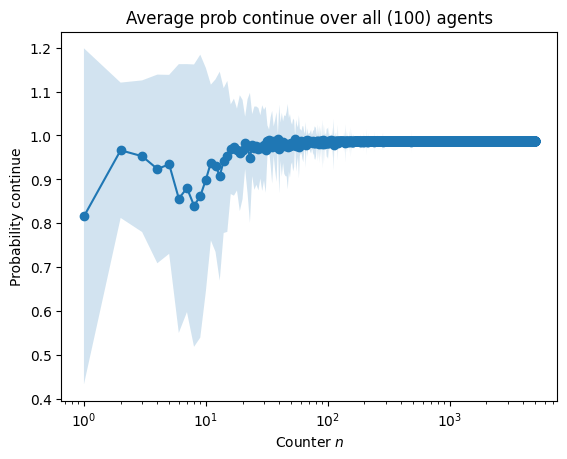

In [ ]:
#initial probability
#plt.plot(np.arange(1, np.shape(h_matrix)[2]+1), initial_prob_distr[0], 'k', '--')

#policy continue
x = np.arange(1, np.shape(h_matrix)[2]+1)
y = np.mean(prob_continue,axis=0)
error = np.std(prob_continue, axis=0)

#plot
plt.plot(x, y,'o-'); plt.fill_between(x, y-error, y+error, alpha=0.2)
#axis
plt.xscale('log'); plt.xlabel('Counter $n$')
plt.ylabel('Probability continue'); #plt.yticks(np.arange(0, 1.1, 0.2), np.arange(0, 1.1, 0.2))
plt.title('Average prob continue over all (100) agents')

Text(0.5, 1.0, 'Prob. continue for each agent')

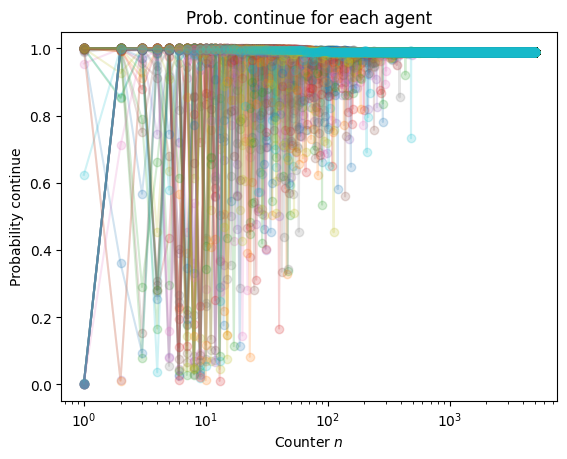

In [ ]:
#initial probability
#plt.plot(np.arange(1, np.shape(h_matrix)[2]+1), initial_prob_distr[0], 'k', '--')

#policy continue
x = np.arange(1, np.shape(h_matrix)[2]+1)

#plot
for a in range(np.shape(h_matrix)[0]):
    plt.plot(x, prob_continue[a,:],'o-', alpha=0.2)
#axis
plt.xscale('log'); plt.xlabel('Counter $n$')
plt.ylabel('Probability continue'); #plt.yticks(np.arange(0, 1.1, 0.2), np.arange(0, 1.1, 0.2))
plt.title('Prob. continue for each agent')

#### Separation of populations according to policies

<matplotlib.legend.Legend>

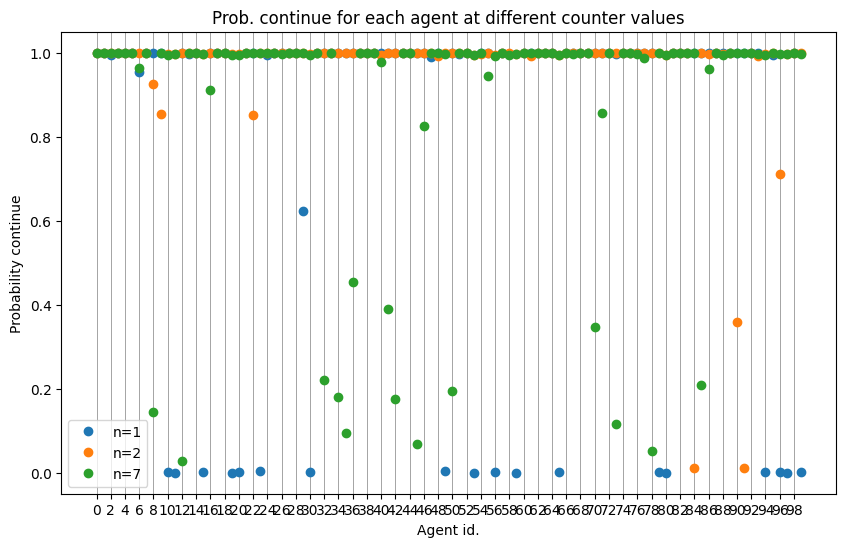

In [ ]:

plt.figure(figsize=(10, 6))

plt.plot(prob_continue[:,0],'o', label='n=1')
plt.plot(prob_continue[:,1], 'o', label='n=2')
plt.plot(prob_continue[:,6], 'o', label='n=7')

plt.xticks(np.arange(0, 100, 2))

plt.grid(True, which='both', axis='x', linestyle='-', linewidth=0.5, color='grey')

# Set the labels and title
plt.xlabel('Agent id.')
plt.ylabel('Probability continue')
plt.title('Prob. continue for each agent at different counter values')

# Add a legend
plt.legend()


It does not look like there is a clear separation of agents in terms of the policies they learned. It looks as if agents learn to turn at different values of the counter, like n=3,4,5,6,etc.

#### Separation of populations according to reward

Separation of populations based on reward. Threshold in R_th (defined above).

In [ ]:
R_th = 0.018

In [ ]:
import os
import numpy as np

# Use best_pair from previous code
gamma_best, eta_best = best_pair

# Recreate the folder path for the best hyperparameters
folder_best = f"{base_folder}gamma_{gamma_best:.6f}_eta_{eta_best:.4f}/"
rewards_path = os.path.join(folder_best, 'rewards.npy')

# Check if file exists
if os.path.exists(rewards_path):
    # Load h_matrix
    rewards = np.load(rewards_path, mmap_mode='r')  # memory-mapped if large
    print(f"rewards loaded with shape: {rewards.shape}")
else:
    print(f"File not found: {rewards_path}")


rewards loaded with shape: (100, 1200)


In [ ]:
pop_highR = np.where(np.mean(rewards[:,-50:],axis=1) > R_th)
pop_lowR = np.where(np.mean(rewards[:,-50:],axis=1) < R_th)

In [ ]:
pop_highR

(array([10, 11, 15, 19, 20, 23, 30, 49, 53, 56, 59, 65, 79, 80, 94, 96, 97,
        99], dtype=int64),)

In [ ]:
len(pop_highR[0])

18

Text(100, 0.5, 'Reward = 0.016')

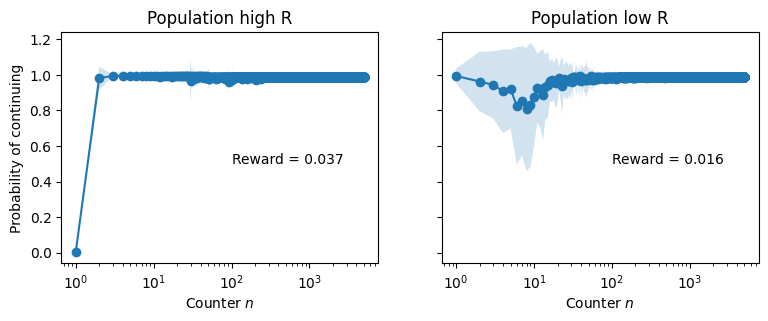

In [ ]:
#initial probability
#plt.plot(np.arange(1, np.shape(h_matrix)[2]+1), initial_prob_distr[0], 'k', '--')

#policy continue
x = np.arange(1, np.shape(h_matrix)[2]+1)
y1 = np.mean(prob_continue[pop_highR,:][0],axis=0)
y2 = np.mean(prob_continue[pop_lowR,:][0],axis=0)
error1 = np.std(prob_continue[pop_highR,:][0], axis=0)
error2 = np.std(prob_continue[pop_lowR,:][0], axis=0)

fig, axs = plt.subplots(1, 2, figsize=(9, 3), sharey=True)
axs[0].plot(x, y1,'o-'); axs[0].fill_between(x, y1-error1, y1+error1, alpha=0.2)
axs[1].plot(x, y2,'o-'); axs[1].fill_between(x, y2-error2, y2+error2, alpha=0.2)

axs[0].set_title('Population high R'); axs[1].set_title('Population low R')
axs[0].set_ylabel('Probability of continuing')
for ax in axs:
    ax.set_xscale('log'); ax.set_xlabel('Counter $n$')

axs[0].text(100, 0.5,'Reward = '+str(np.round(np.mean(rewards[pop_highR, -100:]),3)))
axs[1].text(100, 0.5,'Reward = '+str(np.round(np.mean(rewards[pop_lowR, -100:]),3)))

#### Best agent's policy

Best agent's policy (from average of last 50 episodes (each episode - 5000 steps)):

In [ ]:
best_a = np.where(np.mean(rewards[:,-50:],axis=1) == max(np.mean(rewards[:,-50:],axis=1)))

In [ ]:
best_a[0]

array([97], dtype=int64)

In [ ]:
prob_left = get_prob_action(1, h_matrix)

In [ ]:
prob_right = get_prob_action(2, h_matrix)

[None,
 Text(0.5, 0, 'Counter $n$'),
 -0.1,
 1.05,
 None,
 Text(0.5, 0, 'Counter $n$'),
 -0.1,
 1.05,
 None,
 Text(0.5, 0, 'Counter $n$'),
 -0.1,
 1.05]

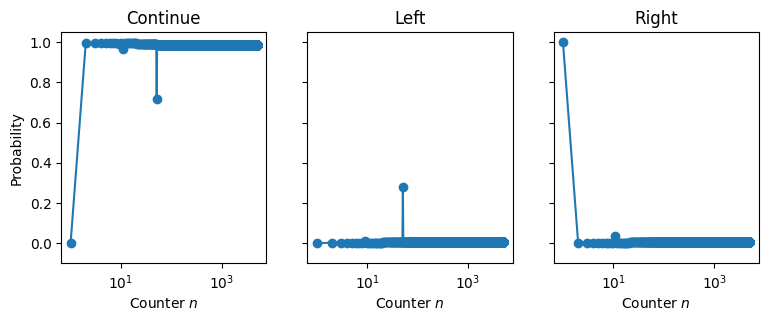

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(9, 3), sharey=True)
axs[0].plot(x, prob_continue[best_a[0][0],:],'o-')
axs[1].plot(x, prob_left[best_a[0][0],:],'o-')
axs[2].plot(x, prob_right[best_a[0][0],:],'o-')
#axis
axs[0].set_title('Continue'); axs[1].set_title('Left');axs[2].set_title('Right')
axs[0].set_ylabel('Probability')

plt.setp(axs, xscale = 'log', xlabel = 'Counter $n$', ylim = (-0.1,1.05))



It learns to turn left at counter n=50:

In [ ]:
np.where(prob_continue[best_a[0][0],:]<0.8)

(array([ 0, 50], dtype=int64),)

h matrix of the best agent for the first 10 counter values. -> values of 6000 in most probable action.

In [ ]:
h_matrix[best_a,:,:10]

array([[[[4.37736013e+00, 4.51790851e+00, 3.50766420e+00,
          3.35862776e+00, 3.29378917e+00, 3.38467660e+00,
          3.19793069e+00, 3.29001114e+00, 3.36581823e+00,
          3.00528521e+00],
         [6.00000000e-03, 6.00000000e-03, 6.00000000e-03,
          6.00000000e-03, 6.00000000e-03, 6.00000000e-03,
          6.00000000e-03, 6.00000000e-03, 2.61100398e-02,
          6.00000000e-03],
         [6.30415283e+03, 6.00000000e-03, 6.00000000e-03,
          6.00000000e-03, 6.00000000e-03, 6.00000000e-03,
          6.00000000e-03, 6.00000000e-03, 6.00000000e-03,
          6.32900346e-03]]]])

### Analysis of the walks (best hyperparameters)

The aim of this test is to check what is the actual performance of the trained (single) agents, in order to pick the best agent's policy. Also to see what the trajectory looks like.

In [ ]:
#| export
import numba
import numpy as np
from rl_opts.robot_search import parallel_robots_trajectories

In [ ]:
policies = get_policies(h_matrix)

In [ ]:
folder_best

'C:/Users/andrea/Desktop/collective_foraging/results/single_robot_final/exp_1/gamma_0.000100_eta_0.0400/'

In [ ]:
number_visited_targets, agent_positions, target_positions, _ = parallel_robots_trajectories(time_ep = int(1e6),
                                                                                             N_agents = 100,
                                                                                             Nt = Nt,
                                                                                             L = L,
                                                                                             r = r,
                                                                                             tau = tau,
                                                                                             agent_radius = agent_radius,
                                                                                             avg_vel=avg_vel,
                                                                                             std_vel=std_vel,
                                                                                             avg_turn_angle=avg_turn_angle,
                                                                                             std_turn_angle=std_turn_angle,
                                                                                             policies = policies)
                                                                                             

np.save(folder_best+'post_training_number_targets.npy', number_visited_targets)
np.save(folder_best+'post_training_trajectories.npy', agent_positions)
np.save(folder_best+'post_training_targets.npy', target_positions)

In [ ]:
np.shape(number_visited_targets)

(100,)

In [ ]:
number_visited_targets

array([15411., 14698., 16126., 14475., 15178., 14990., 16466., 14982.,
       16099., 16570., 30094., 47914., 16529., 14973., 14184., 44578.,
       14106., 14387., 14667., 44659., 42087., 15436., 16083., 34558.,
       15121., 14230., 15274., 15739., 16088., 15244., 37296., 15847.,
       14967., 15408., 14843., 14297., 15129., 15425., 16059., 14764.,
       15662., 14612., 15240., 16012., 17519., 16100., 15150., 15701.,
       14626., 27882., 14952., 16045., 15102., 35532., 15221., 14128.,
       35339., 16141., 15481., 38366., 15478., 16165., 15040., 14354.,
       16311., 38057., 16615., 16103., 15594., 15602., 15379., 15130.,
       15537., 15780., 15719., 15041., 15696., 13839., 15871., 49615.,
       36542., 18970., 15044., 15167., 16031., 13979., 14887., 14748.,
       15848., 15066., 16022., 14726., 15406., 15637., 42324., 15125.,
       43217., 35149., 16565., 33431.])

#### 1 agent output: best performing agent in the post-training walk

Agent that got more targets in the post-walk:

In [ ]:
agent_index = np.argmax(number_visited_targets)

In [ ]:
agent_index

79

In [ ]:
number_visited_targets[agent_index]

49615.0

In [ ]:
np.mean(rewards[:,-50:],axis=1)[agent_index]

0.039992

We pick the agent that now got more targets and see policy, and analysis of the walk

Policy:

[None,
 Text(0.5, 0, 'Counter $n$'),
 Text(0, 0.5, 'Probability'),
 -0.1,
 1.1,
 None,
 Text(0.5, 0, 'Counter $n$'),
 Text(0, 0.5, 'Probability'),
 -0.1,
 1.1,
 None,
 Text(0.5, 0, 'Counter $n$'),
 Text(0, 0.5, 'Probability'),
 -0.1,
 1.1]

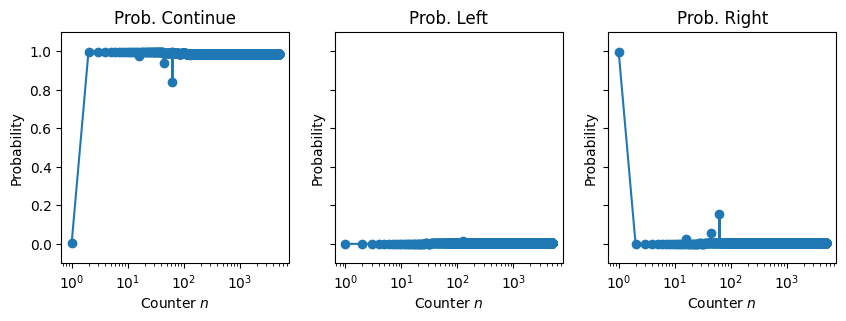

In [ ]:
fig_traj, ax_traj = plt.subplots(1, 3, figsize=(10, 3), sharey=True)
ax_traj[0].plot(x, prob_continue[agent_index,:],'o-')
ax_traj[1].plot(x, prob_left[agent_index,:],'o-')
ax_traj[2].plot(x, prob_right[agent_index,:],'o-')

ax_traj[0].set_title('Prob. Continue'); ax_traj[1].set_title('Prob. Left'); ax_traj[2].set_title('Prob. Right')

plt.setp(ax_traj, xscale = 'log', xlabel = 'Counter $n$', ylabel = 'Probability', ylim = (-0.1,1.1))

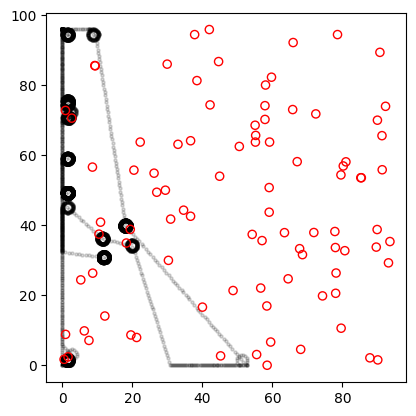

In [ ]:
fig_world, ax_world = plt.subplots()
plt.scatter(agent_positions[agent_index,:5500,0], agent_positions[agent_index,:5500,1], color='k', alpha=0.15, s=5)
plt.scatter(target_positions[agent_index,:,0], target_positions[agent_index,:,1], color = 'r', s=35, facecolors='none')
plt.plot([0,2],[0,0],'k')
ax_world.set_aspect('equal')


Other agents that also got very good performances now:

In [ ]:
best_pop = np.where(number_visited_targets >30000)

In [ ]:
best_pop

(array([10, 11, 15, 19, 20, 23, 30, 53, 56, 59, 65, 79, 80, 94, 96, 97, 99],
       dtype=int64),)

In [ ]:
other_agent = 20

In [ ]:
number_visited_targets[other_agent]

42087.0

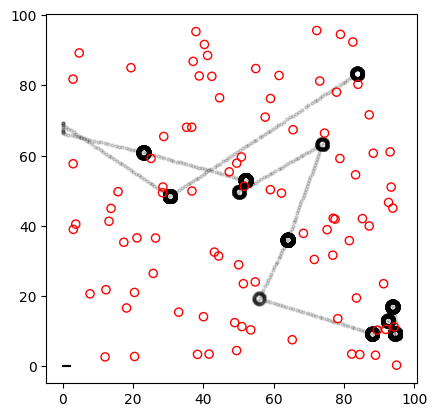

In [ ]:
fig_world, ax_world = plt.subplots()
plt.scatter(agent_positions[other_agent,:9500,0], agent_positions[other_agent,:9500,1], color='k', alpha=0.15, s=5)
plt.scatter(target_positions[other_agent,:,0], target_positions[other_agent,:,1], color = 'r', s=35, facecolors='none')
plt.plot([0,2],[0,0],'k')
ax_world.set_aspect('equal')


[None,
 Text(0.5, 0, 'Counter $n$'),
 Text(0, 0.5, 'Probability'),
 -0.1,
 1.1,
 None,
 Text(0.5, 0, 'Counter $n$'),
 Text(0, 0.5, 'Probability'),
 -0.1,
 1.1,
 None,
 Text(0.5, 0, 'Counter $n$'),
 Text(0, 0.5, 'Probability'),
 -0.1,
 1.1]

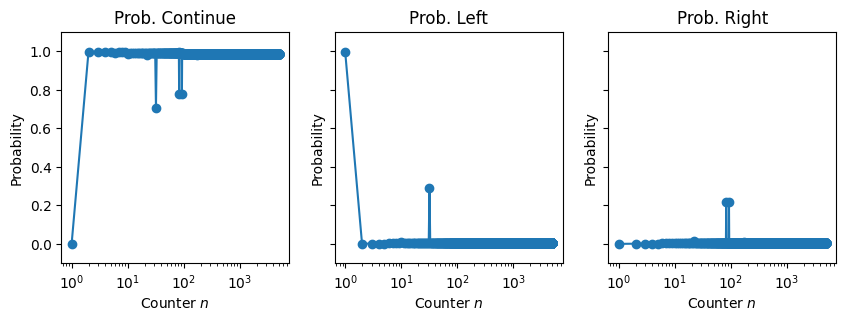

In [ ]:
fig_traj, ax_traj = plt.subplots(1, 3, figsize=(10, 3), sharey=True)
ax_traj[0].plot(x, prob_continue[other_agent,:],'o-')
ax_traj[1].plot(x, prob_left[other_agent,:],'o-')
ax_traj[2].plot(x, prob_right[other_agent,:],'o-')

ax_traj[0].set_title('Prob. Continue'); ax_traj[1].set_title('Prob. Left'); ax_traj[2].set_title('Prob. Right')

plt.setp(ax_traj, xscale = 'log', xlabel = 'Counter $n$', ylabel = 'Probability', ylim = (-0.1,1.1))

#### Worst performing agents in the post-training walk

In [ ]:
worst_pop = np.where(number_visited_targets < 20000)

In [ ]:
worst_pop

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 12, 13, 14, 16, 17, 18, 21,
        22, 24, 25, 26, 27, 28, 29, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40,
        41, 42, 43, 44, 45, 46, 47, 48, 50, 51, 52, 54, 55, 57, 58, 60, 61,
        62, 63, 64, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 81,
        82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 95, 98],
       dtype=int64),)

In [ ]:
bad_agent_index = 1

In [ ]:
number_visited_targets[bad_agent_index]

14698.0

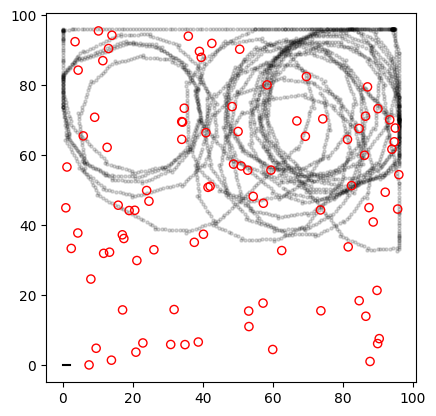

In [ ]:
fig_world, ax_world = plt.subplots()
plt.scatter(agent_positions[bad_agent_index,:3500,0], agent_positions[bad_agent_index,:3500,1], color='k', alpha=0.15, s=5)
plt.scatter(target_positions[bad_agent_index,:,0], target_positions[bad_agent_index,:,1], color = 'r', s=35, facecolors='none')
plt.plot([0,2],[0,0],'k')
ax_world.set_aspect('equal')


[None,
 Text(0.5, 0, 'Counter $n$'),
 Text(0, 0.5, 'Probability'),
 -0.1,
 1.1,
 None,
 Text(0.5, 0, 'Counter $n$'),
 Text(0, 0.5, 'Probability'),
 -0.1,
 1.1,
 None,
 Text(0.5, 0, 'Counter $n$'),
 Text(0, 0.5, 'Probability'),
 -0.1,
 1.1]

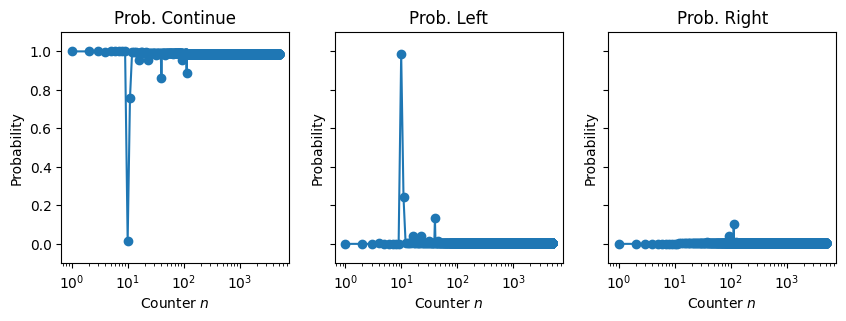

In [ ]:
fig_traj, ax_traj = plt.subplots(1, 3, figsize=(10, 3), sharey=True)
ax_traj[0].plot(x, prob_continue[bad_agent_index,:],'o-')
ax_traj[1].plot(x, prob_left[bad_agent_index,:],'o-')
ax_traj[2].plot(x, prob_right[bad_agent_index,:],'o-')

ax_traj[0].set_title('Prob. Continue'); ax_traj[1].set_title('Prob. Left'); ax_traj[2].set_title('Prob. Right')

plt.setp(ax_traj, xscale = 'log', xlabel = 'Counter $n$', ylabel = 'Probability', ylim = (-0.1,1.1))

## EXP_2

Trajectory of the agent that performed the best in the last 10000 steps of the training.

In [ ]:
best_a

15

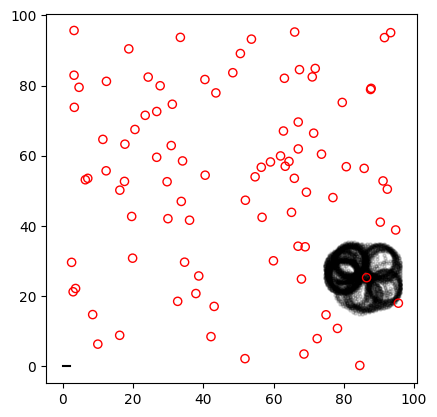

In [ ]:
fig_world, ax_world = plt.subplots()
plt.scatter(agent_positions[best_a,:3500,0], agent_positions[best_a,:3500,1], color='k', alpha=0.15, s=5)
plt.scatter(target_positions[best_a,:,0], target_positions[best_a,:,1], color = 'r', s=35, facecolors='none')
plt.plot([0,2],[0,0],'k')
ax_world.set_aspect('equal')
